In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
import sys; sys.path.append("../offline/")
import sparse, geom, utils

In [6]:
fname = "../data/r%04d_lowq.h5" 

In [616]:
runs = np.arange(82,120)

In [617]:
radial_data, radial_fit = [],[]
diameter, intensity = [],[]
cx,cy, error, runnr = [],[],[],[]
runtag, index = [],[]
for run in runs:
    with sparse.SmallFrame(fname %run, geometry="../geometry/b3_lowq.geom") as f:
        runnr.append(run*np.ones(f.nframes))
        runtag.append(run + np.linspace(-0.4,0.4,f.nframes))
        index.append(np.arange(f.nframes))
        radial_data.append(f._handle["radial_data"][:])
        radial_fit.append(f._handle["radial_fit"][:])
        diameter.append(f._handle["diameter"][:])
        intensity.append(f._handle["intensity"][:])
        cx.append(f._handle["cx"][:])
        cy.append(f._handle["cy"][:])
        error.append(f._handle["error_test"][:])
radial_data = np.vstack(radial_data)
radial_fit = np.vstack(radial_fit)
diameter = np.hstack(diameter) * 1e9
intensity = np.hstack(intensity) / (1e-3 / 1e-12)
cx = np.hstack(cx)
cy = np.hstack(cy)
error = np.hstack(error)
runnr = np.hstack(runnr)
runtag = np.hstack(runtag)
index = np.hstack(index)

In [618]:
valid = (error >= 1) & (diameter > 30) & (intensity <5)

(20, 320)

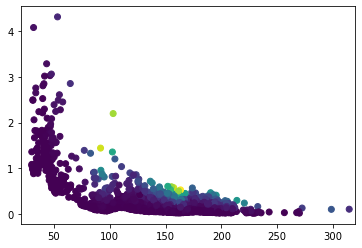

In [619]:
plt.scatter(diameter[valid], intensity[valid], c=error[valid])
plt.xlim(20,320)

In [620]:
peak_mean1, peak_std1 = [],[]
peak_mean2, peak_std2 = [],[]
intensity_hist, diameter_hist = [],[]
small_size = []
for run in runs:
    r = (runnr[valid] == run)
    I = intensity[valid][r]
    D = diameter[valid][r]
    k1 = 0.05*I.shape[0]
    k2 = 0.7*I.shape[0]
    peak_mean1.append(np.sort(I)[-int(k1):].mean())
    peak_std1.append(np.sort(I)[-int(k1):].std())
    peak_mean2.append(np.sort(I)[-5:].mean())
    peak_std2.append(np.sort(I)[-5:].std())
    HI,bI = np.histogram(I, range=(0,1),bins=100)
    HD,bD = np.histogram(D, range=(0,100),bins=55)
    intensity_hist.append(HI)
    diameter_hist.append(HD)
    small_size.append((D<75).sum())
peak_mean1 = np.hstack(peak_mean1)
peak_std1 = np.hstack(peak_std1)
peak_mean2 = np.hstack(peak_mean2)
peak_std2 = np.hstack(peak_std2)
intensity_hist = np.vstack(intensity_hist)
diameter_hist = np.vstack(diameter_hist)
small_size = np.hstack(small_size)

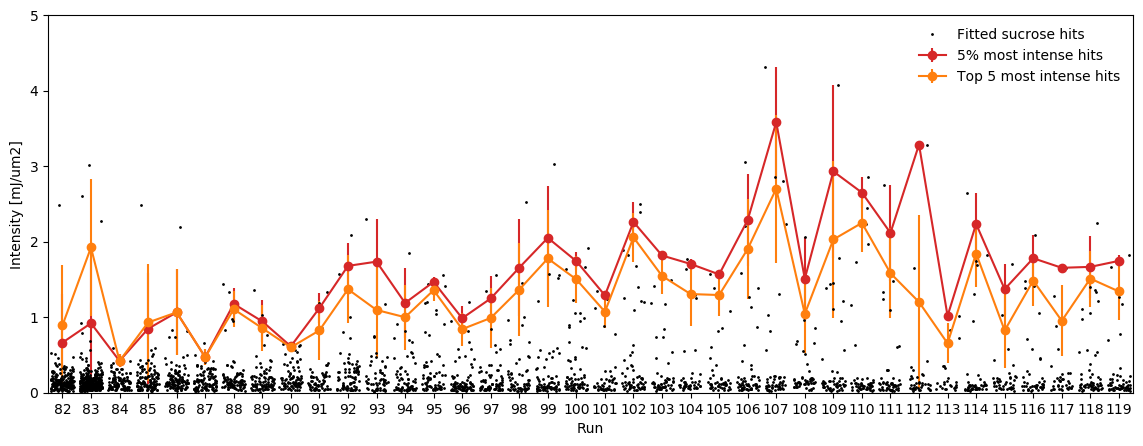

In [621]:
plt.figure(figsize=(14,5), dpi=100)
plt.errorbar(runs, peak_mean1, peak_std1, marker='o', color='tab:red', label='5% most intense hits')
plt.errorbar(runs, peak_mean2, peak_std2, marker='o', color='tab:orange', label='Top 5 most intense hits')
plt.plot(runtag[valid], intensity[valid], 'k.', ms=2, label="Fitted sucrose hits")
plt.ylabel("Intensity [mJ/um2]")
plt.xticks(runs)
plt.xlabel("Run")
plt.legend(frameon=0)
plt.ylim(0,5)
plt.xlim(runs[0]-0.5, runs[-1]+0.5)
plt.savefig("sucrose_intensity.png")
plt.show()

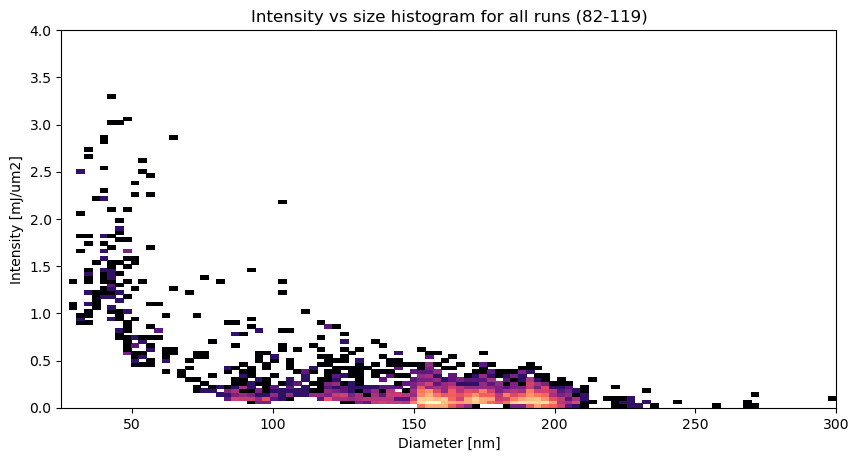

In [622]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Intensity vs size histogram for all runs (82-119)")
plt.hist2d(diameter[valid], intensity[valid], range=((25,300),(0,4)), bins=100, norm=colors.LogNorm(), cmap='magma')
plt.xlabel("Diameter [nm]")
plt.ylabel("Intensity [mJ/um2]")
plt.xlim(25,300)
plt.savefig("size_vs_intensity.png")
plt.show()

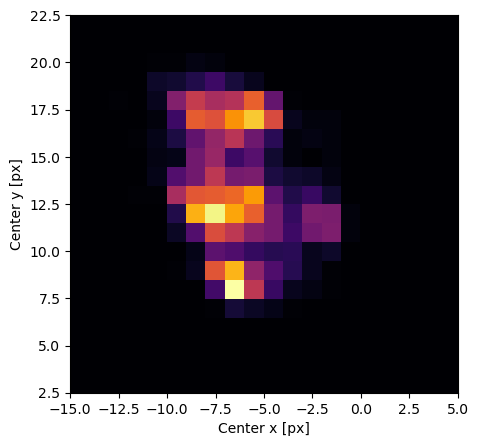

In [623]:
plt.figure(figsize=(5,5), dpi=100)
plt.hist2d(cx[valid],cy[valid], range=((-15,5),(2.5,22.5)), bins=20, cmap='inferno')
plt.xlabel("Center x [px]")
plt.ylabel("Center y [px]")
plt.show()

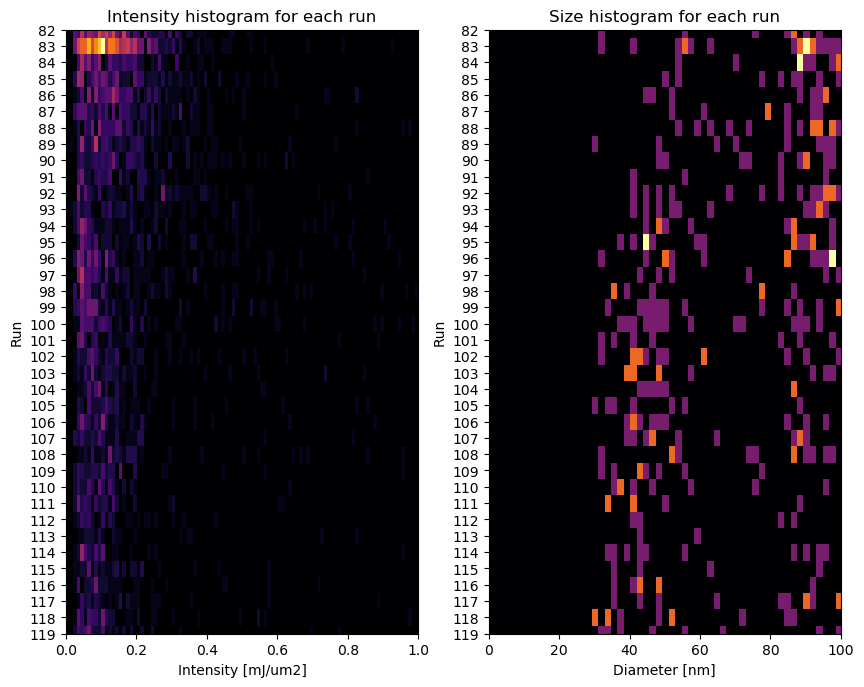

In [624]:
fig, axes = plt.subplots(ncols=2, figsize=(10,8), dpi=100)
axes[0].set_title("Intensity histogram for each run")
axes[0].imshow(intensity_hist, aspect='auto', cmap='inferno', 
           extent=[0,1, runs[-1]+1, runs[0]])
axes[0].set_yticks(runs+0.5)
axes[0].set_yticklabels(runs)
axes[0].set_ylabel("Run")
axes[0].set_xlabel("Intensity [mJ/um2]")
axes[1].set_title("Size histogram for each run")
axes[1].imshow(diameter_hist, aspect='auto', cmap='inferno', #norm=colors.LogNorm(),
           extent=[0,100, runs[-1]+1, runs[0]])
axes[1].set_yticks(runs+0.5)
axes[1].set_yticklabels(runs)
axes[1].set_ylabel("Run")
axes[1].set_xlabel("Diameter [nm]")
plt.savefig("intensity_histograms.png")
plt.show()

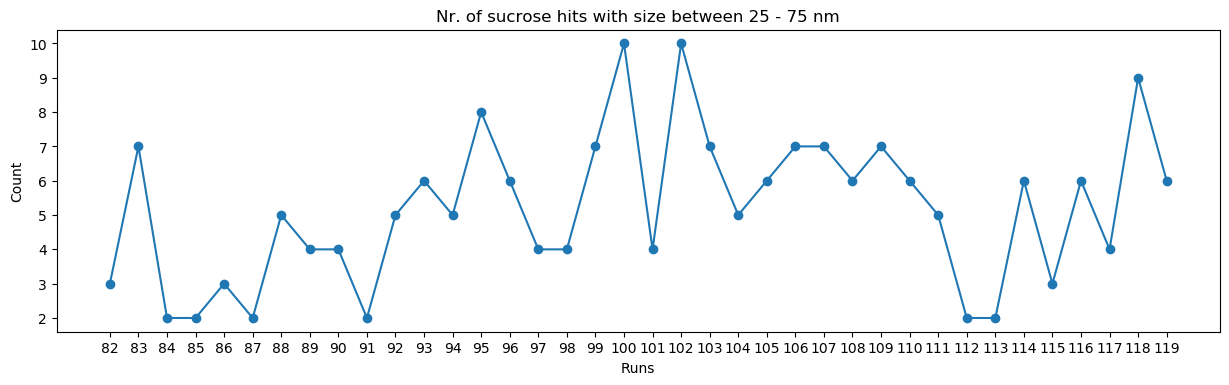

In [625]:
plt.figure(figsize=(15,4), dpi=100)
plt.title("Nr. of sucrose hits with size between 25 - 75 nm")
plt.plot(runs, small_size, marker='o')
plt.xticks(runs)
plt.xlabel("Runs")
plt.ylabel("Count")
plt.show()

In [626]:
selection = (intensity[valid]>1)
sel_idx = index[valid][selection]
sel_run = runnr[valid][selection]
sel_int = intensity[valid][selection]
sel_dia = diameter[valid][selection]
sel_err = error[valid][selection]
N = selection.sum()
print(N)

128


In [627]:
ncols = 10
nrows = N//ncols+1

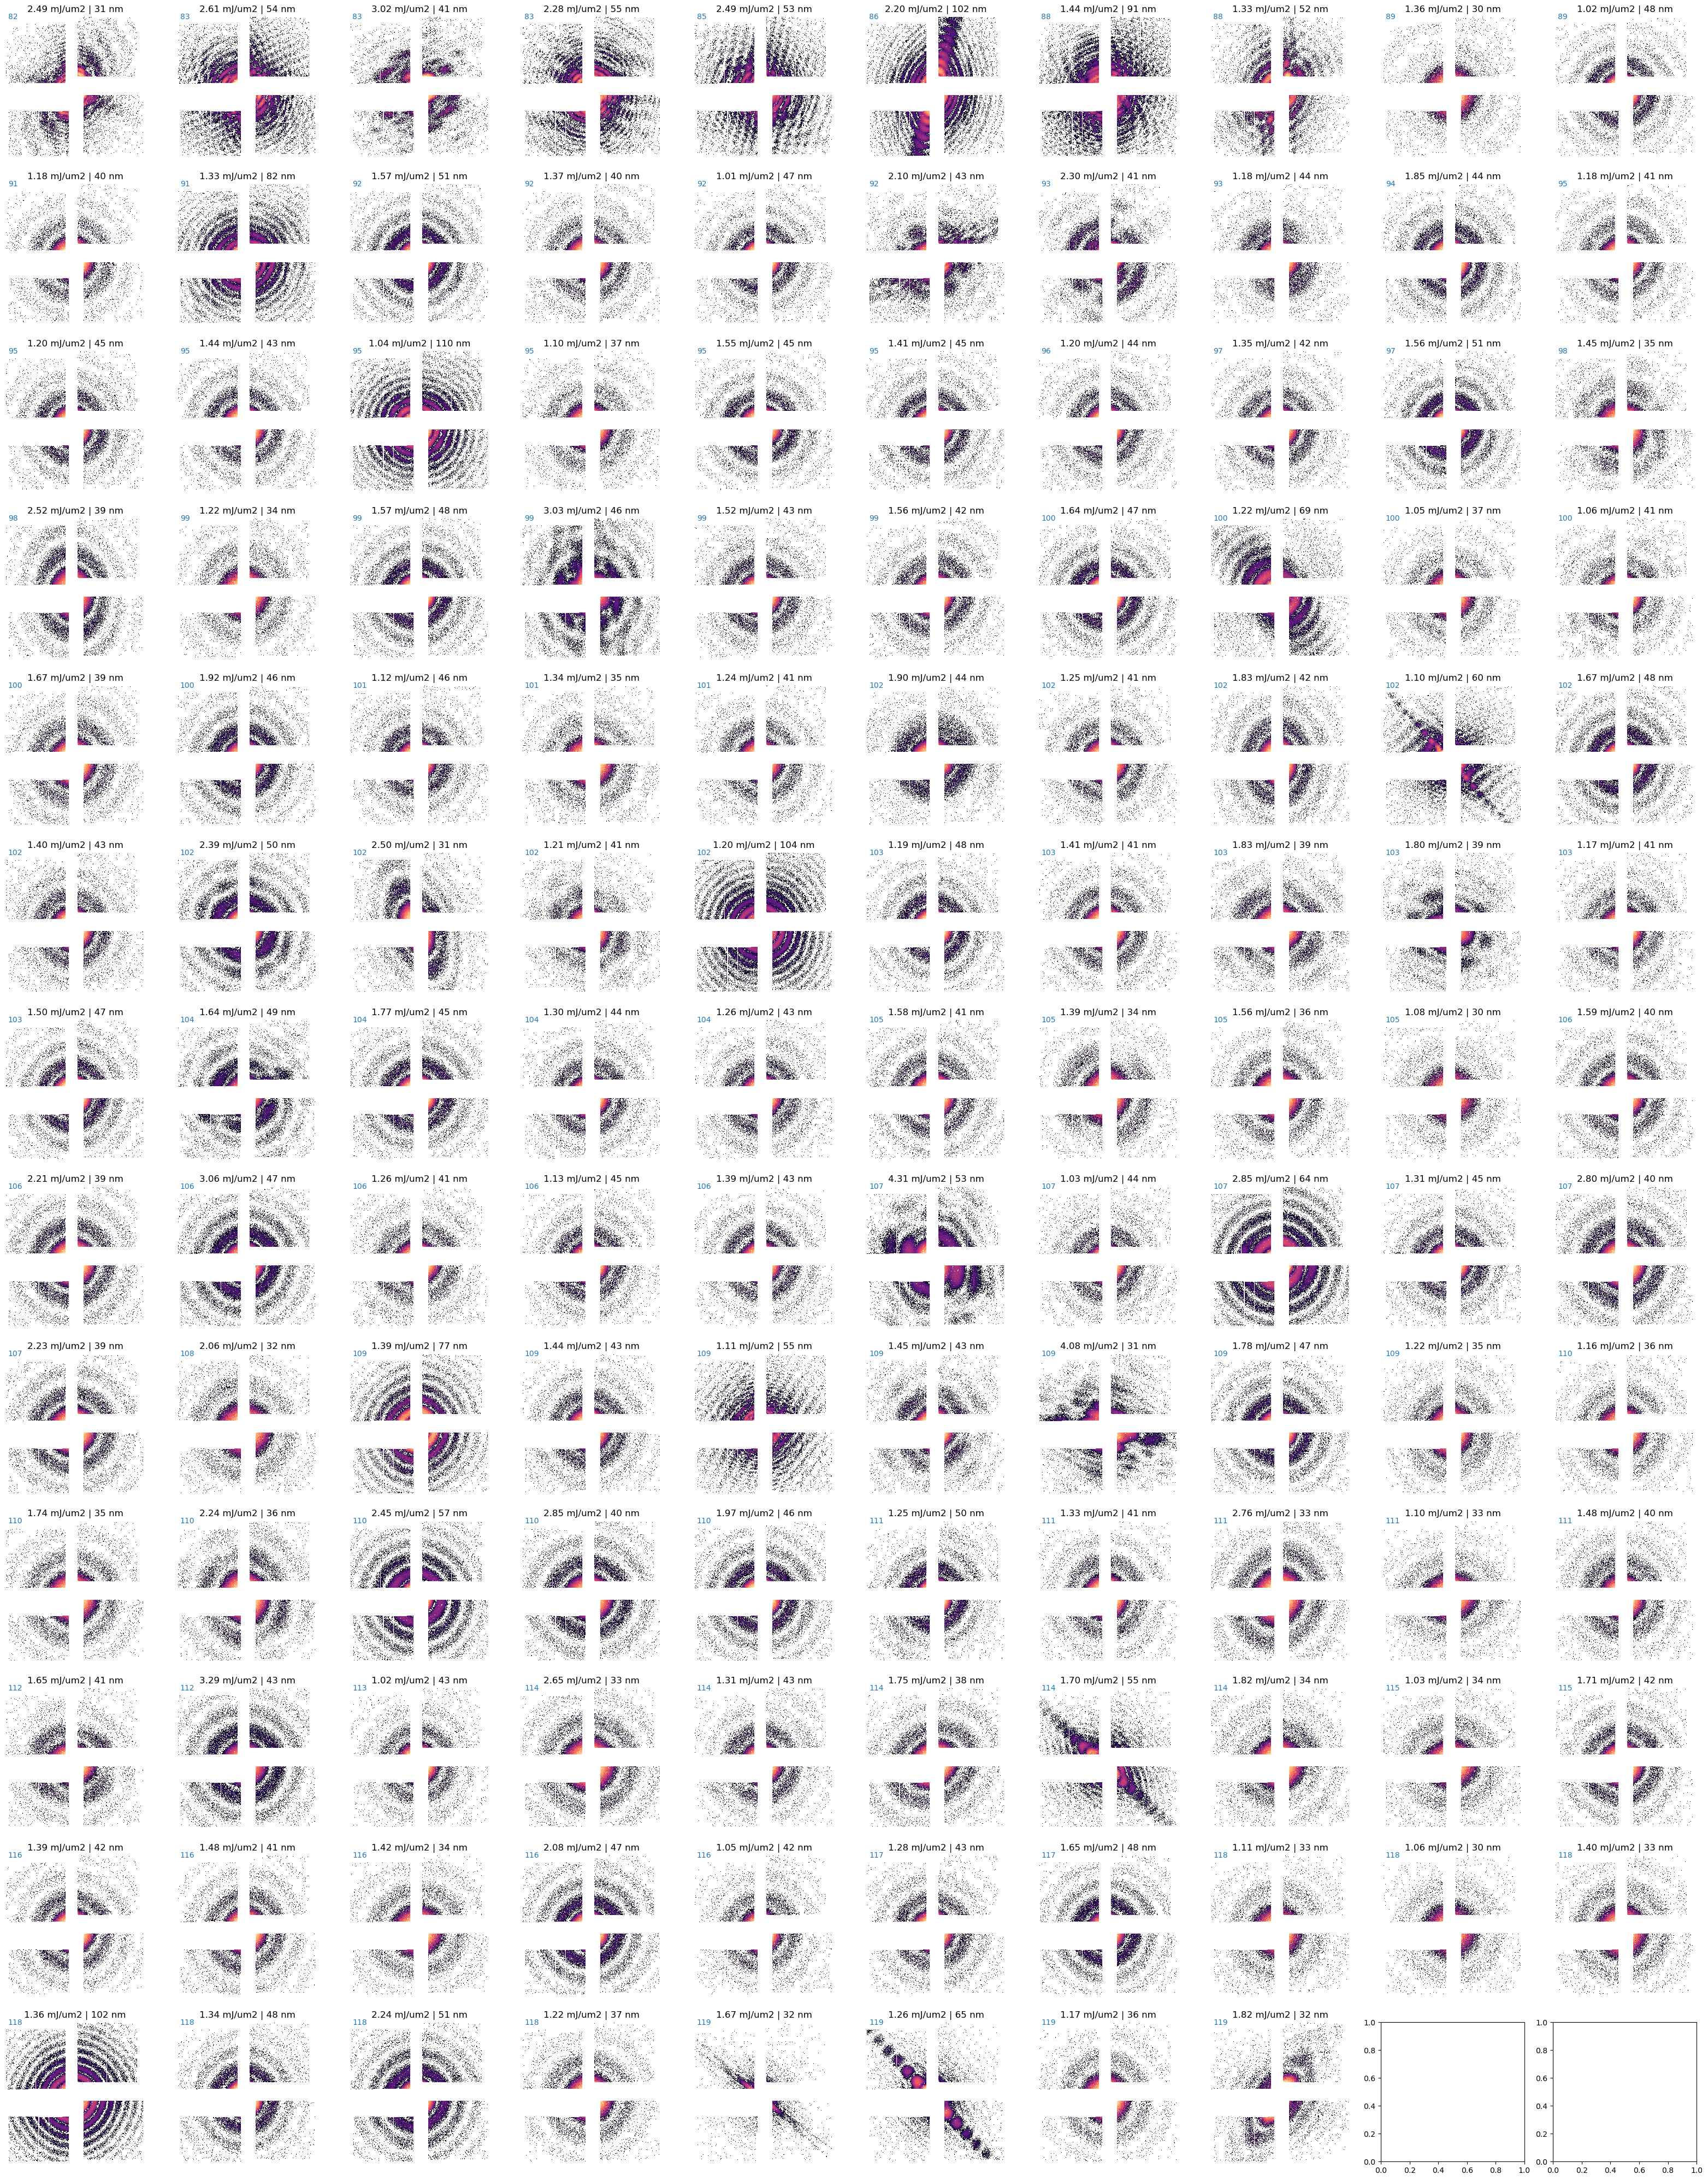

In [628]:
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*4), dpi=100)
for i in range(N):
    with sparse.SmallFrame(fname %sel_run[i], geometry="../geometry/b3_lowq.geom") as f:
        img = f.assembled(sel_idx[i])[:300,:300]
        k = i//ncols
        l = i%ncols
        axes[k,l].axis('off')
        axes[k,l].set_title("%.2f mJ/um2 | %d nm" %(sel_int[i], sel_dia[i]))
        axes[k,l].imshow(img, norm=colors.LogNorm(), cmap='magma')
        axes[k,l].text(5,5, "%d" %sel_run[i], color='tab:blue')
plt.show()